# Email Spam Classifier

**Context**

The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.

[Source: Kaggle](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset)

**Tasks:**

- Data cleaning
- EDA
- Text preprocessing
- Model building
- Evaluation
- Improvement
- Create web application

**Main Task:**

* Build a prediction model that will accurately classify which texts are spam.

In [123]:
import numpy as np
import pandas as pd


In [124]:
df = pd.read_csv("../data/spam.csv", encoding='ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


## Data cleaning

In [126]:
# Drop unnamed columns
df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1, inplace=True)
df.sample(4)

,v1,v2
4,ham,"Nah I don't think he goes to usf, he lives aro..."
3694,ham,"Hello, As per request from &lt;#&gt; Rs.5 ha..."
3454,ham,No need lar. Jus testing e phone card. Dunno n...
2675,ham,I'm sick !! I'm needy !! I want you !! *pouts*...


In [127]:
# Renaming the columns
df.rename(columns={'v1': 'label', 'v2': 'text'}, inplace=True)
df.sample(2)

,label,text
5296,ham,Are u coming to the funeral home
507,ham,You should know now. So how's anthony. Are you...


In [128]:
# convert to numeric the target column
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

df['label'] = encoder.fit_transform(df['label'])
df.head(3)

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...


In [129]:
# check missing values
df.isna().sum()

label    0
text     0
dtype: int64

In [130]:
# check duplicates values
df.duplicated().sum()

403

In [131]:
# remove duplicates values
df = df.drop_duplicates(keep='first')

df.duplicated().sum()

0

## Exploratory Data Analysis (EDA)

In [132]:
df['label'].value_counts()

label
0    4516
1     653
Name: count, dtype: int64

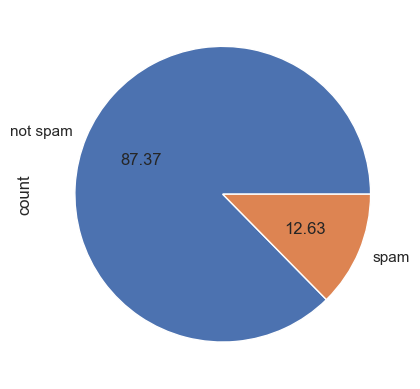

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

df['label'].value_counts().plot(kind='pie', labels = ['not spam', 'spam'], autopct='%0.2f');

* We have imbalanced data

In [134]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [135]:
# Adding column -> number of characters
df['number_characters'] = df['text'].apply(len)
df.head()

,label,text,number_characters
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [136]:
# Adding column -> number of words
df['number_words'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))
df.head()

,label,text,number_characters,number_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


In [137]:
# Adding column -> number of sentences
df['number_sentences'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))
df.head()

,label,text,number_characters,number_words,number_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [138]:
df.columns

Index(['label', 'text', 'number_characters', 'number_words',
       'number_sentences'],
      dtype='object')

In [139]:
df[['number_characters', 
    'number_words',
    'number_sentences']].describe(percentiles=[0.25, 0.5, 0.75, 0.9 ]).T

,count,mean,std,min,25%,50%,75%,90%,max
number_characters,5169.0,78.977945,58.236293,2.0,36.0,60.0,117.0,155.0,910.0
number_words,5169.0,18.455794,13.324758,1.0,9.0,15.0,26.0,34.0,220.0
number_sentences,5169.0,1.965564,1.448541,1.0,1.0,1.0,2.0,4.0,38.0


In [140]:
df[df['label']==0][['number_characters', 'number_words', 'number_sentences']].describe(percentiles=[0.25, 0.5, 0.75, 0.9 ]).T

,count,mean,std,min,25%,50%,75%,90%,max
number_characters,4516.0,70.459256,56.358207,2.0,34.0,52.0,90.0,142.0,910.0
number_words,4516.0,17.123782,13.493970,1.0,8.0,13.0,22.0,33.0,220.0
number_sentences,4516.0,1.820195,1.383657,1.0,1.0,1.0,2.0,3.0,38.0


In [141]:
df[df['label']==1][['number_characters', 'number_words', 'number_sentences']].describe(percentiles=[0.25, 0.5, 0.75, 0.9 ]).T

,count,mean,std,min,25%,50%,75%,90%,max
number_characters,653.0,137.891271,30.137753,13.0,132.0,149.0,157.0,160.0,224.0
number_words,653.0,27.667688,7.008418,2.0,25.0,29.0,32.0,35.0,46.0
number_sentences,653.0,2.970904,1.488425,1.0,2.0,3.0,4.0,5.0,9.0


<Axes: xlabel='number_characters', ylabel='Count'>

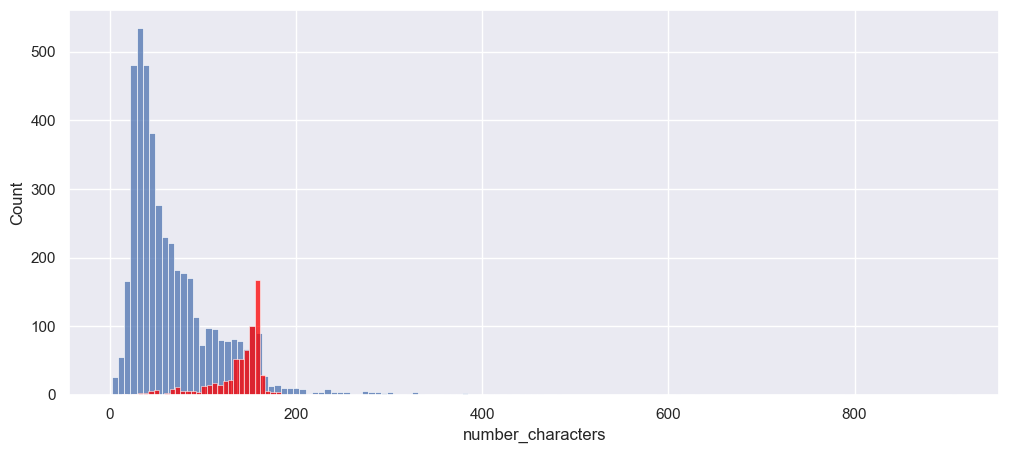

In [142]:
plt.figure(figsize=(12,5))
sns.histplot(df[df['label']==0]['number_characters'])
sns.histplot(df[df['label']==1]['number_characters'], color='red')

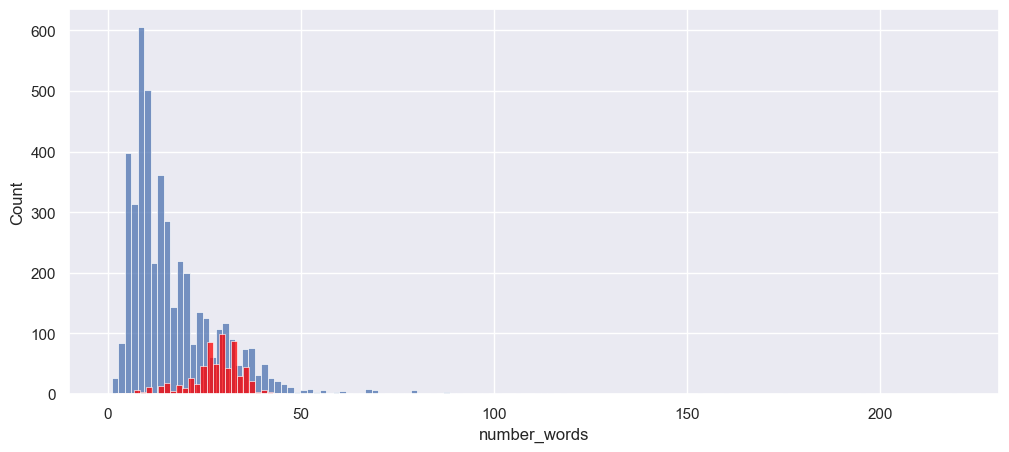

In [143]:
plt.figure(figsize=(12,5))
sns.histplot(df[df['label']==0]['number_words'])
sns.histplot(df[df['label']==1]['number_words'], color='red');

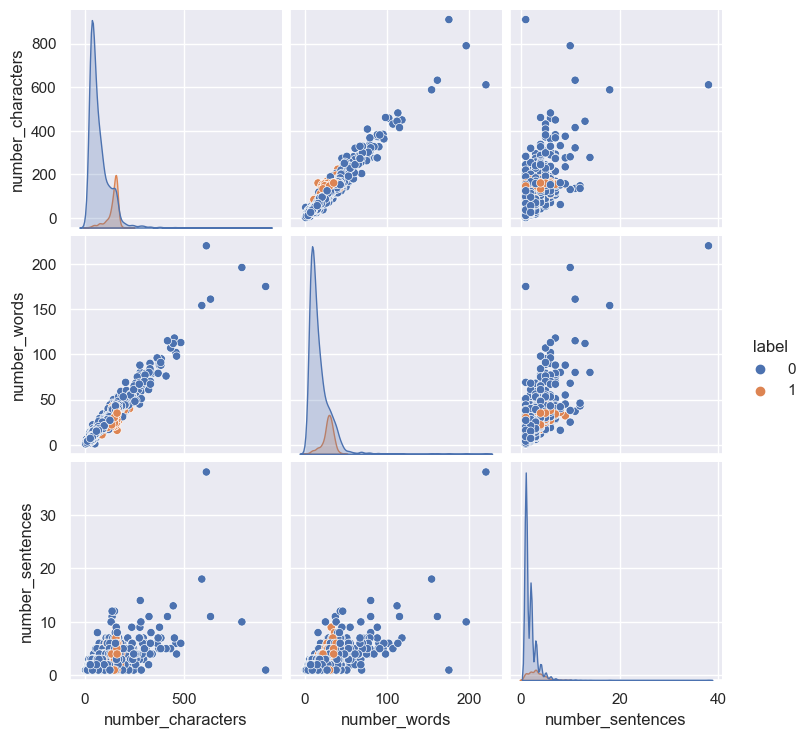

In [144]:
sns.pairplot(data=df, hue='label')

In [145]:
# Select only the numeric columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
corr_matrix = numeric_df.corr()

<Axes: >

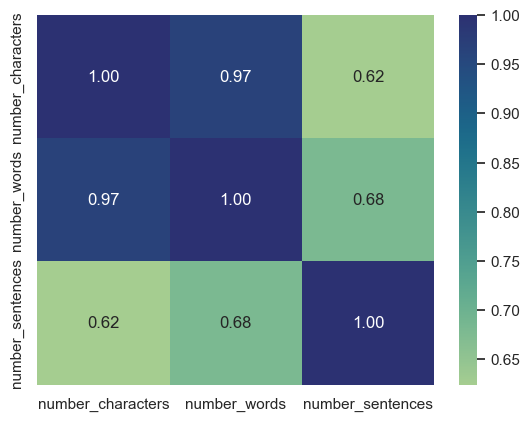

In [146]:
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="crest")

## Data preprocessing

* Lower case
* Tokenization
* Removing special characters
* Removing stopwords and punctuation
* Stemming

In [147]:
from nltk.stem import  PorterStemmer
from nltk.corpus import stopwords
import re

In [148]:
def preprocessing_text(text_raw, stemmer):
    text_raw = str(text_raw)    
    text = text_raw.lower() # convert all characters in the text string to lowercase
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    text = text.split() # tokenize the cleaned text into words
    text = [word for word in text if word != ' ']
    text = [stemmer.stem(word) for word in text if word not in set(stopwords.words('english'))] # lemmatize each word in the cleaned text
    text = ' '.join(text) # concatenate the cleaned and lemmatized words
    return text # return the cleaned and lemmatized text

In [149]:
stemmer = PorterStemmer() # create a lemmatizer object
df['preprocessing_text'] = df['text'].apply(lambda x: preprocessing_text(x,stemmer))
df.head()

,label,text,number_characters,number_words,number_sentences,preprocessing_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [150]:
# wordclod
from wordcloud import WordCloud

wc = WordCloud(width=700, height=700, min_font_size=8, background_color='black')

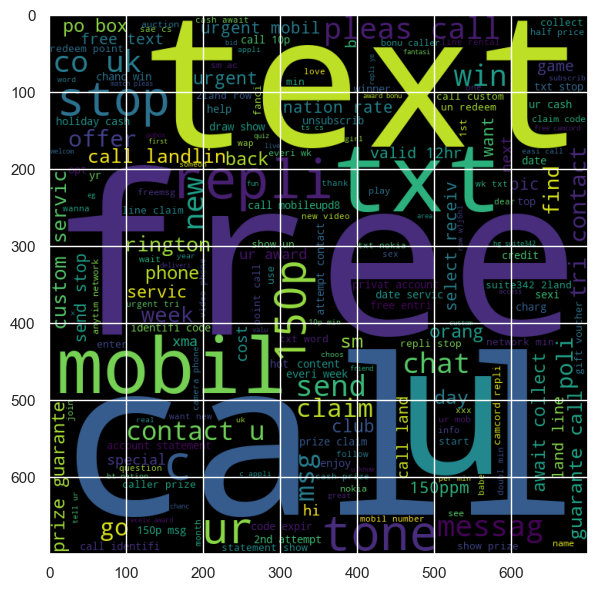

In [151]:
spam_wc = wc.generate(df[df['label']==1]['preprocessing_text'].str.cat(sep=' '))

plt.figure(figsize=(12,7))
plt.imshow(spam_wc);

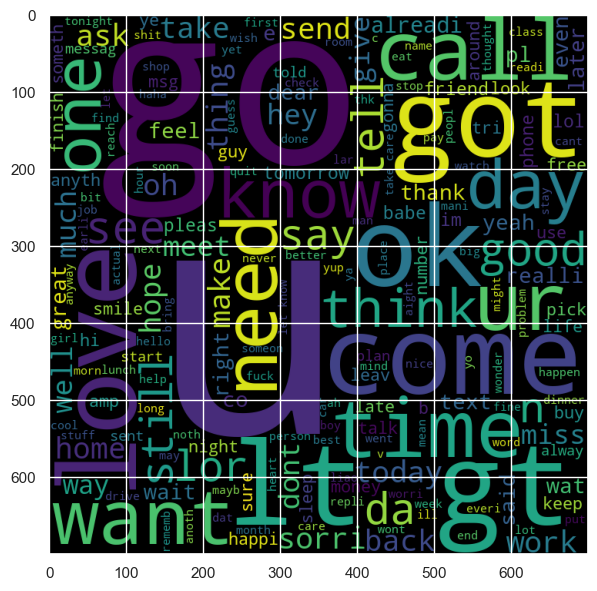

In [152]:
no_spam_wc = wc.generate(df[df['label']==0]['preprocessing_text'].str.cat(sep=' '))

plt.figure(figsize=(12,7))
plt.imshow(no_spam_wc);

In [153]:
# concat all the sentences that be spam
spam_corpus = []
for sentence in df[df['label']==1]['preprocessing_text'].tolist():
    for word in sentence.split():
        spam_corpus.append(word)

In [154]:
len(spam_corpus)

11744

In [155]:
from collections import Counter
Counter(spam_corpus)

Counter({'free': 195,
         'entri': 21,
         '2': 184,
         'wkli': 9,
         'comp': 8,
         'win': 51,
         'fa': 2,
         'cup': 3,
         'final': 14,
         'tkt': 2,
         '21st': 1,
         'may': 6,
         '2005': 2,
         'text': 128,
         '87121': 2,
         'receiv': 31,
         'question': 10,
         'std': 7,
         'txt': 145,
         'rate': 33,
         'c': 51,
         'appli': 25,
         '08452810075over18': 1,
         'freemsg': 14,
         'hey': 5,
         'darl': 2,
         '3': 37,
         'week': 55,
         'word': 21,
         'back': 20,
         'like': 12,
         'fun': 8,
         'still': 5,
         'tb': 2,
         'ok': 5,
         'xxx': 10,
         'chg': 2,
         'send': 61,
         '1': 94,
         '50': 46,
         'rcv': 2,
         'winner': 13,
         'valu': 8,
         'network': 26,
         'custom': 42,
         'select': 26,
         'receivea': 1,
         '900': 6,
  

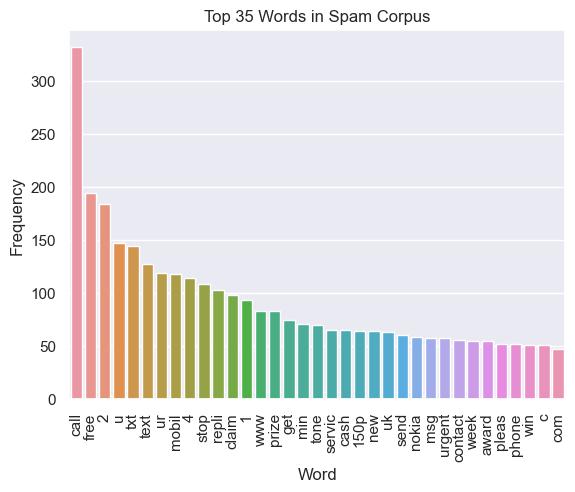

In [159]:
# Count the frequency of each word
word_freq = Counter(spam_corpus)

# Convert the Counter object to a DataFrame
df_frecuency_words = pd.DataFrame.from_dict(word_freq, orient='index', columns=['frequency'])

# Sort the DataFrame by frequency in descending order
df_frecuency_words = df_frecuency_words.sort_values(by='frequency', ascending=False)

# Get the top 35 words and their frequencies
top_words = df_frecuency_words.head(35)

# Create a bar plot of the top 35 words using Seaborn
sns.set_style('darkgrid')
sns.barplot(x=top_words.index, y=top_words['frequency'])
plt.title('Top 35 Words in Spam Corpus')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

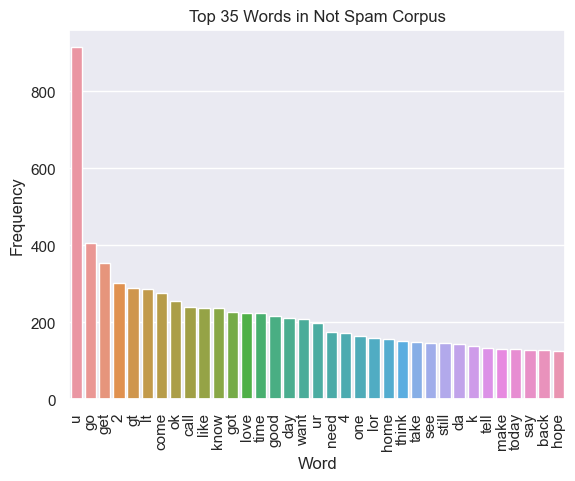

In [158]:
# concat all the sentences that doesn't be spam
not_spam_corpus = []
for sentence in df[df['label']==0]['preprocessing_text'].tolist():
    for word in sentence.split():
        not_spam_corpus.append(word)

# Count the frequency of each word
word_freq = Counter(not_spam_corpus)

# Convert the Counter object to a DataFrame
df_frecuency_words = pd.DataFrame.from_dict(word_freq, orient='index', columns=['frequency'])

# Sort the DataFrame by frequency in descending order
df_frecuency_words = df_frecuency_words.sort_values(by='frequency', ascending=False)

# Get the top 35 words and their frequencies
top_words = df_frecuency_words.head(35)

# Create a bar plot of the top 35 words using Seaborn
sns.set_style('darkgrid')
sns.barplot(x=top_words.index, y=top_words['frequency'])
plt.title('Top 35 Words in Not Spam Corpus')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

## Building model

In [168]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#cv = CountVectorizer()
#X = cv.fit_transform(df['preprocessing_text']).toarray()

tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['preprocessing_text']).toarray()

X.shape


(5169, 7163)

In [169]:
y = df['label'].values
y

array([0, 0, 1, ..., 0, 0, 0])

In [173]:
# PASO ADICIONAL - PARA BALANCEAR EL TARGET
from imblearn.over_sampling import SMOTE
# crear una instancia de SMOTE
sm = SMOTE(random_state=42)
# aplicar SMOTE a X e y
X_smote, y_smote = sm.fit_resample(X, y)

In [176]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)


In [185]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score,recall_score, classification_report


In [186]:
gnb_model = GaussianNB()
mnb_model = MultinomialNB()
bnb_model = BernoulliNB()
rf_model = RandomForestClassifier()

models = {
    'GaussianNB':gnb_model,
    'MultinomialNB':mnb_model,
    'BernoulliNB': bnb_model,
    'RandomForestClassifier':rf_model
}


for name, model in models.items():
    print(f">>>> {name} <<<<<")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f'confusion_matrix: {confusion_matrix(y_test, y_pred)}')
    print(f'accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'precision: {precision_score(y_test, y_pred)}, \n')
    print(classification_report(y_test, y_pred), '\n')


>>>> GaussianNB <<<<<


confusion_matrix: [[765 119]
 [  0 923]]
accuracy: 0.9341449916989485
precision: 0.8857965451055663, 

              precision    recall  f1-score   support

           0       1.00      0.87      0.93       884
           1       0.89      1.00      0.94       923

    accuracy                           0.93      1807
   macro avg       0.94      0.93      0.93      1807
weighted avg       0.94      0.93      0.93      1807
 

>>>> MultinomialNB <<<<<
confusion_matrix: [[864  20]
 [  8 915]]
accuracy: 0.9845047039291643
precision: 0.9786096256684492, 

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       884
           1       0.98      0.99      0.98       923

    accuracy                           0.98      1807
   macro avg       0.98      0.98      0.98      1807
weighted avg       0.98      0.98      0.98      1807
 

>>>> BernoulliNB <<<<<
confusion_matrix: [[883   1]
 [ 18 905]]
accuracy: 0.9894853348090759
precision: 0.99889

In [187]:
# Applying for more models

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier


In [188]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)

models = {
    'SVC' : svc,
    'KN' : knc, 
    'NB': mnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'BgC': bc, 
    'ETC': etc,
    'GBDT':gbdt,
    'xgb':xgb
}

In [189]:
# crear un diccionario vacío para guardar la evaluación de los modelos
evaluation = {}

# iterar sobre los modelos y calcular sus métricas
for name, model in models.items():
    print(f">>>> {name} <<<<<")

    # entrenar el modelo con los datos de entrenamiento
    model.fit(X_train, y_train)

    # predecir las etiquetas de los datos de prueba
    y_pred = model.predict(X_test)

    # calcular la exactitud (accuracy), la precisión (precision) y el recall del modelo
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)

    # mostrar las métricas por pantalla
    print(f'accuracy: {acc}')
    print(f'precision: {prec}')
    print(f'recall: {rec}\n')

    # guardar las métricas en el diccionario de evaluación usando el nombre del modelo como clave y una tupla o una lista como valor
    evaluation[name] = (acc, prec, rec)

>>>> SVC <<<<<


accuracy: 0.9928057553956835
precision: 0.9913606911447084
recall: 0.9945828819068255

>>>> KN <<<<<
accuracy: 0.9900387382401771
precision: 0.9956188389923329
recall: 0.9848320693391116

>>>> NB <<<<<
accuracy: 0.9845047039291643
precision: 0.9786096256684492
recall: 0.991332611050921

>>>> DT <<<<<
accuracy: 0.9263973436635307
precision: 0.9582366589327146
recall: 0.894907908992416

>>>> LR <<<<<
accuracy: 0.9739900387382402
precision: 0.9802631578947368
recall: 0.9685807150595883

>>>> RF <<<<<
accuracy: 0.993912562257886
precision: 0.9989059080962801
recall: 0.9891657638136512

>>>> AdaBoost <<<<<
accuracy: 0.9828444936358606
precision: 0.9890350877192983
recall: 0.9772481040086674

>>>> BgC <<<<<
accuracy: 0.9789706696181516
precision: 0.976318622174381
recall: 0.9826652221018418

>>>> ETC <<<<<
accuracy: 0.9966795794133924
precision: 0.997828447339848
recall: 0.9956663055254604

>>>> GBDT <<<<<
accuracy: 0.9601549529607084
precision: 0.9680968096809681
recall: 0.9534127843986999


In [213]:
# crear un dataframe a partir del diccionario de evaluación
df_metrics = pd.DataFrame(evaluation, index=['accuracy', 'precision', 'recall'])

# transponer el dataframe para tener los nombres de los modelos como índice
df_metrics = df_metrics.T

# add algorithm name column
#df_metrics['algorithm'] = df_metrics.index.tolist()#['SVC','KN', 'NB','DT','LR','RF','AdaBoost','BgC','ETC','GBDT','xgb']

# ordenar el dataframe por la columna de accuracy en orden descendente
df_metrics = df_metrics.sort_values(by='accuracy', ascending=False)
df_metrics = df_metrics.reset_index()
df_metrics = df_metrics.rename({'index':'Algorithm'}, axis=1)
# mostrar el dataframe resultante
df_metrics

,Algorithm,accuracy,precision,recall
0,ETC,0.996680,0.997828,0.995666
1,RF,0.993913,0.998906,0.989166
2,SVC,0.992806,0.991361,0.994583
3,KN,0.990039,0.995619,0.984832
4,xgb,0.986165,0.990175,0.982665
5,NB,0.984505,0.978610,0.991333
6,AdaBoost,0.982844,0.989035,0.977248
7,BgC,0.978971,0.976319,0.982665
8,LR,0.973990,0.980263,0.968581
9,GBDT,0.960155,0.968097,0.953413


<Axes: >

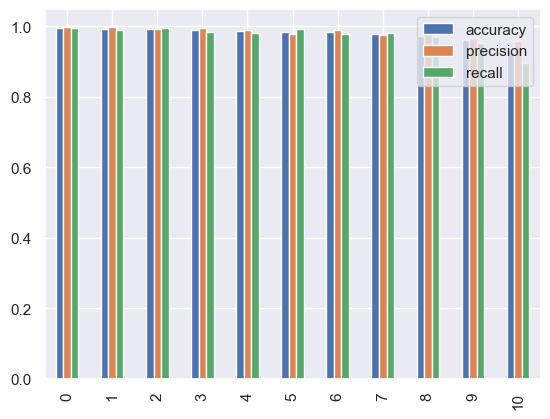

In [222]:
df_metrics.plot(kind='bar')

In [223]:
# modify the max features to 3000
# =================================================================

tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['preprocessing_text']).toarray()


#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()
#X = scaler.fit_transform(X)


# BALANCEAR EL TARGET
from imblearn.over_sampling import SMOTE
# crear una instancia de SMOTE
sm = SMOTE(random_state=42)
# aplicar SMOTE a X e y
X_smote, y_smote = sm.fit_resample(X, y)



from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)


svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)

models = {
    'SVC' : svc,
    'KN' : knc, 
    'NB': mnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'BgC': bc, 
    'ETC': etc,
    'GBDT':gbdt,
    'xgb':xgb
}

# crear un diccionario vacío para guardar la evaluación de los modelos
evaluation2 = {}

# iterar sobre los modelos y calcular sus métricas
for name, model in models.items():
    print(f">>>> {name} <<<<<")

    # entrenar el modelo con los datos de entrenamiento
    model.fit(X_train, y_train)

    # predecir las etiquetas de los datos de prueba
    y_pred = model.predict(X_test)

    # calcular la exactitud (accuracy), la precisión (precision) y el recall del modelo
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)

    # mostrar las métricas por pantalla
    print(f'accuracy: {acc}')
    print(f'precision: {prec}')
    print(f'recall: {rec}\n')

    # guardar las métricas en el diccionario de evaluación usando el nombre del modelo como clave y una tupla o una lista como valor
    evaluation2[name] = (acc, prec, rec)

# crear un dataframe a partir del diccionario de evaluación
df_metrics2 = pd.DataFrame(evaluation2, index=['accuracy', 'precision', 'recall'])

# transponer el dataframe para tener los nombres de los modelos como índice
df_metrics2 = df_metrics2.T

# add algorithm name column
#df_metrics['algorithm'] = df_metrics.index.tolist()#['SVC','KN', 'NB','DT','LR','RF','AdaBoost','BgC','ETC','GBDT','xgb']

# ordenar el dataframe por la columna de accuracy en orden descendente
df_metrics2 = df_metrics2.sort_values(by='accuracy', ascending=False)
df_metrics2 = df_metrics2.reset_index()
df_metrics2 = df_metrics2.rename({'index':'Algorithm'}, axis=1)
# mostrar el dataframe resultante

df_metrics2

>>>> SVC <<<<<
accuracy: 0.9701162147205312
precision: 0.9854748603351955
recall: 0.9555796316359697

>>>> KN <<<<<
accuracy: 0.7509684560044272
precision: 0.6742815033161386
recall: 0.991332611050921

>>>> NB <<<<<
accuracy: 0.9795240730492529
precision: 0.9794372294372294
recall: 0.980498374864572

>>>> DT <<<<<
accuracy: 0.9092418372993912
precision: 0.9469964664310954
recall: 0.8710725893824486

>>>> LR <<<<<
accuracy: 0.9551743220807969
precision: 0.979498861047836
recall: 0.9317443120260022

>>>> RF <<<<<
accuracy: 0.9905921416712784
precision: 0.9967105263157895
recall: 0.9848320693391116

>>>> AdaBoost <<<<<
accuracy: 0.9701162147205312
precision: 0.9811738648947951
recall: 0.9599133261105092

>>>> BgC <<<<<
accuracy: 0.9762036524626453
precision: 0.9700854700854701
recall: 0.9837486457204767

>>>> ETC <<<<<
accuracy: 0.9928057553956835
precision: 0.9924242424242424
recall: 0.9934994582881906

>>>> GBDT <<<<<
accuracy: 0.9496402877697842
precision: 0.9653243847874721
recall: 0.

,Algorithm,accuracy,precision,recall
0,ETC,0.992806,0.992424,0.993499
1,RF,0.990592,0.996711,0.984832
2,NB,0.979524,0.979437,0.980498
3,xgb,0.978417,0.986784,0.970748
4,BgC,0.976204,0.970085,0.983749
5,SVC,0.970116,0.985475,0.955580
6,AdaBoost,0.970116,0.981174,0.959913
7,LR,0.955174,0.979499,0.931744
8,GBDT,0.949640,0.965324,0.934995
9,DT,0.909242,0.946996,0.871073


In [226]:
# export preprocessing model and best model
import pickle
pickle.dump(tfidf, open('preprocessor.pkl','wb'))

best_model = evaluation2.get("ETC")
pickle.dump(best_model, open('model.pkl','wb'))
